# TP : Réseaux de neurones convolutionnels



## 1. Filtres et convolutions

Dans cette première partie du TP, nous allons explorer l'effet de plusieurs filtres de convolutions classiques.
Le code ci dessous charge une image et l'affiche; on travaillera sur cette image dans la première partie du TP.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
import PIL.Image as PIMG
import numpy as np


def showImage(img:np.ndarray, m=None, M=None)->None:
    plt.imshow(img, cmap='gray', vmin=m, vmax=M)
    _ = plt.colorbar()
    plt.show()

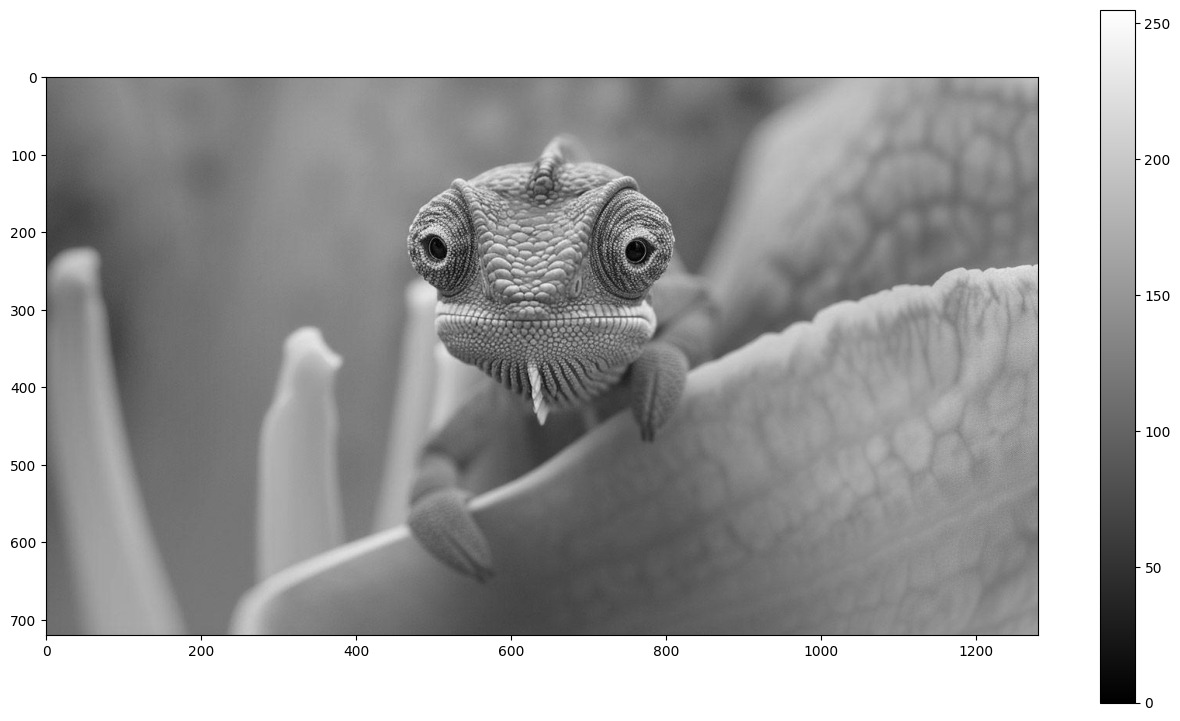

In [2]:
img = np.array(PIMG.open('cameleon.jpg'))
showImage(img)

**Q1**: Completez la fonction ci dessous, qui prend en paramètre une image (en niveau de gris) et un filtre (tous deux sous forme de `np.array`), et renvoie l'image obtenue en applicant la convolution du filtre et de l'image.
On supposera que le décalage (stride) est égal à 1, et qu'il n'y a pas de padding.


In [3]:
def convolution(img:np.ndarray, filtre:np.ndarray, zerosPadding:bool=False, verbose:bool=True)->np.ndarray:
    s0F, s1F = filtre.shape
    filtre = filtre.astype("float32")
    
    if zerosPadding is True:
        tmp = np.zeros((img.shape[0]+(s0F-1), img.shape[1]+(s1F-1)), dtype=img.dtype)
        xMid = (s0F-1) // 2
        yMid = (s0F-1) // 2
        tmp[xMid: tmp.shape[0]-(s0F-1-xMid), xMid: tmp.shape[1]-(s1F-1-xMid)] = img
        img = tmp
        del tmp, xMid, yMid
    s0, s1 = img.shape
    
    imgOut: np.ndarray = np.zeros((s0-(s0F-1), s1-(s1F-1)), dtype=np.float32)
    for xF in range(s0F):
        for yF in range(s1F):
            imgPortion = img[xF: s0-(s0F-xF)+1, yF: s1-(s1F-yF)+1]
            imgOut[:, :] += (filtre[xF, yF] * imgPortion)
    if verbose: 
        print(f"{imgOut.shape=} | (min, max)={(imgOut.min(), imgOut.max())}")
    return imgOut


On va maintenant utiliser cette fonction pour faire de la détection de contours dans notre image.
Pour cela, on va utiliser les [filtres de Sobel](https://fr.wikipedia.org/wiki/Filtre_de_Sobel) associés aux matrices $G_x$ et $G_y$, définies par:
$$G_x = \begin{pmatrix}-1 & 0 & 1 \\ -2 & 0 & 2\\-1 & 0 & 1 \\\end{pmatrix} \text{ et } G_y = \begin{pmatrix}-1 & -2 & -1 \\ 0 & 0 & 0\\1 & 2 & 1 \\\end{pmatrix}$$

**Q2**: Intuitivement, quel est l'effet du filtre $G_x$ sur l'image ? Et $G_y$ ?

> ils detectent les bordures dans la direction X et Y respectivement

**Q3**: Calculer les images $I_x$ et $I_y$ obtenues en faisant la convolution de l'image d'entrée avec $G_x$ et $G_y$.
Pour visualiser les contours, afficher l'image $I = abs(I_x) + abs(I_y)$. L'opération $abs$ correspond à la valeur absolue, i.e. la fonction `np.abs`.
Pour un meilleur résultat, on pourra limiter les valeurs à 255, en réduisant les valeurs au dessus à 255.

imgOut.shape=(3, 3) | (min, max)=(-4.0, 4.0)
[[-4.  0.  4.]
 [ 0.  0.  0.]
 [ 4.  0. -4.]]
imgOut.shape=(718, 1278) | (min, max)=(-677.0, 722.0)
imgOut.shape=(718, 1278) | (min, max)=(-668.0, 642.0)


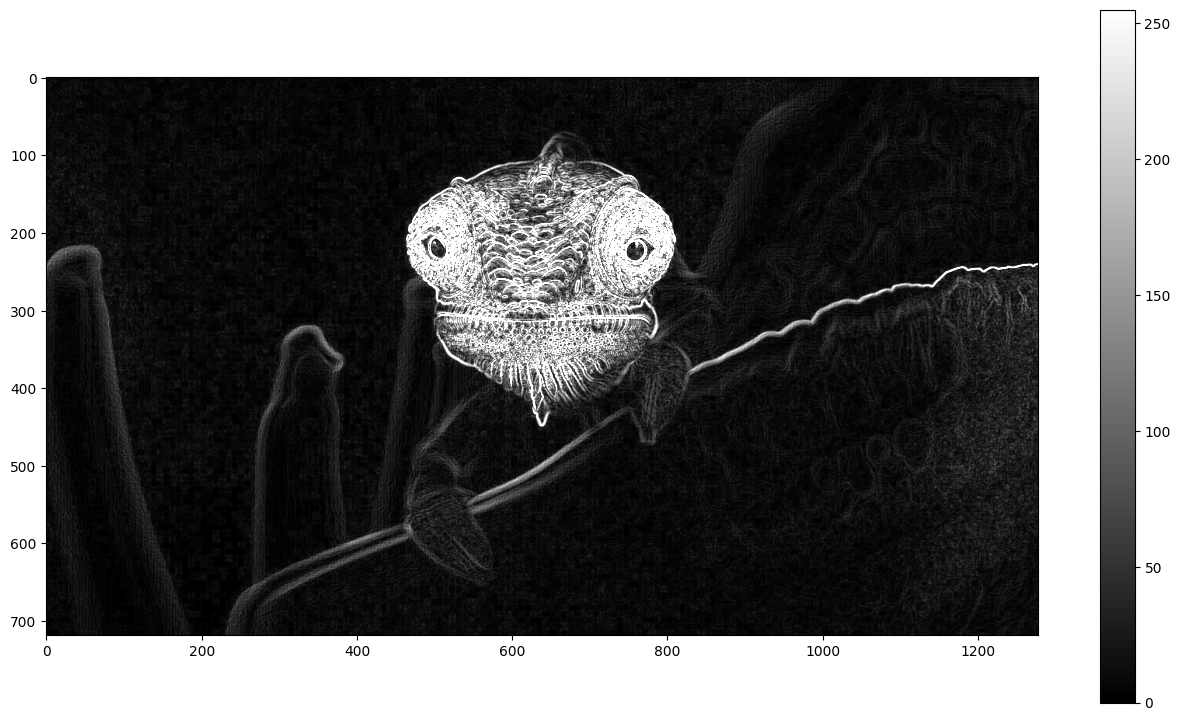

In [4]:
# showImage(convolution(img, getGaussianFilter2D(20)))
filtre_Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
filtre_Gy = filtre_Gx.T
filtre_G2 = convolution(filtre_Gx, filtre_Gy, zerosPadding=True)
print(filtre_G2)

#showImage(np.clip(convolution(img, filtre_Gy), 0, 255))
#showImage(np.clip(convolution(img, filtre_Gx), 0, 255))
#showImage(np.clip(convolution(img, filtre_G2), 0, 255))
showImage(np.abs(convolution(img, filtre_Gx)) + np.abs(convolution(img, filtre_Gy)), 0, 255)

## 2. Réseaux Convolutionnels pour la reconnaissance de chiffres

Dans la seconde partie du TP, nous allons comparer la performance de réseaux multilayer perceptron (MLP) à celle des réseaux convolutionnels pour un problème classique de classification d'images: reconnaître le chiffre dessiné sur une image.

In [5]:
import torch
import torch.nn.functional as F
import torchvision.datasets as ds
from torchvision import transforms

getDevice = lambda: torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = getDevice()
print(device)

cuda


Commençons par charger et visualiser les données.

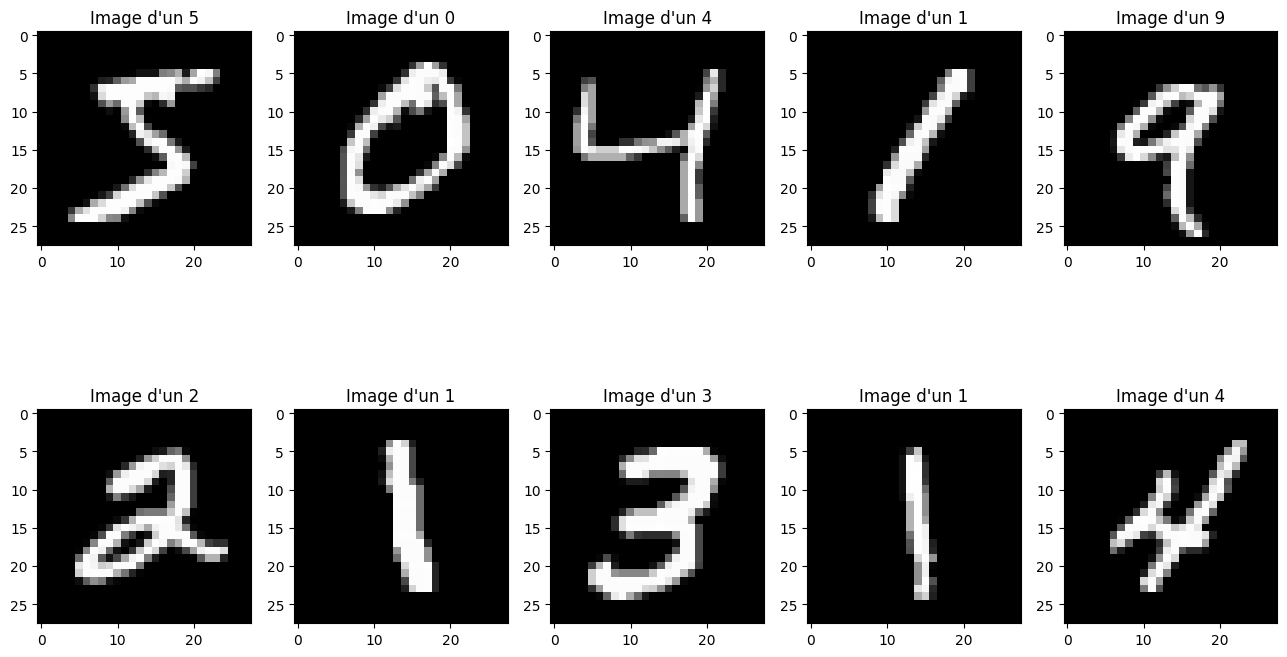

In [6]:
# Chargement et visualisation des données :
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])
target_transform = lambda x: F.one_hot(torch.tensor(x, dtype=torch.long), num_classes=10).type(torch.float)
data_train = ds.MNIST(root="./data", train=True, transform=transform, target_transform=target_transform, download=False)
data_test = ds.MNIST(root="./data", train=False, transform=transform, target_transform=target_transform, download=False)


for i in range(10):
    plt.subplot(2,5,i+1)
    img = data_train.data[i, :, :]
    plt.title(f"Image d'un {data_train.targets[i]}")
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
data_train.data.shape, data_train.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [8]:
import torch.utils.data

batch_size = 1_000
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True)

train_datas: list[tuple[torch.Tensor, torch.Tensor]] = list(train_loader)
test_datas: list[tuple[torch.Tensor, torch.Tensor]] = list(test_loader)

Ensuite, on va entraîner un modèle avec des layers linéaires (dense). La définition du modèle est la suivante :

In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features=28*28, out_features=32)
        self.layer2 = torch.nn.Linear(in_features=32, out_features=10)

    def forward(self, x):
        # Flatten input
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.layer1(x))
        y = self.layer2(x)
        return y

In [10]:
from tqdm import tqdm
from profilers import Profiler, prettyTime

def validate(model, loss):
    with torch.no_grad():
        val_loss = 0
        nb_correct = 0
        for x, target in test_datas:
            x = x.to(device); target = target.to(device)
            output = model(x)
            val_loss += loss(output, target).item()
            nb_correct += sum(np.argmax(output.cpu(), axis=1) == np.argmax(target.cpu(), axis=1))
    return val_loss/len(data_test.data), nb_correct/len(data_test.data)

def train_epoch(model, optimizer, loss, verbose:bool=True):
    train_loss = 0
    _prof = Profiler(["gather", "toDevice", "zeroGrad", "forward", "loss", "backwartd", "step"])
    getter = iter(train_datas)
    while True:
        with _prof.mesure("gather"):
            try: x, target = next(getter)
            except StopIteration: break
        with _prof.mesure("toDevice"):
            x = x.to(device); target = target.to(device)
        with _prof.mesure("zeroGrad"):
            optimizer.zero_grad()

        with _prof.mesure("forward"):
            output = model(x)
        with _prof.mesure("loss"):
            error = loss(output, target)

        with _prof.mesure("backwartd"):
            error.backward()
        with _prof.mesure("step"):
            optimizer.step()

        train_loss += error.item()
    if verbose:
        _prof.showTotalTimesPrecent()
        print(f"-> total={prettyTime(sum(_prof.totalTimes().values()))}")
    return train_loss / len(data_train.data)


In [11]:
from torch.optim import Adam
device = "cpu"
mlp = MLP().to(device)

# Optimizer
optimizer = Adam(mlp.parameters(), lr=0.001)

# Loss function
loss = torch.nn.CrossEntropyLoss()

# Number of epochs
num_epochs = 20

In [12]:
val_loss, prec = validate(mlp, loss)
print(f"Initial prec: {prec*100:.3f}%")
for e in range(num_epochs):
    #print(f"epoch n°{e+1}, training ...")
    train_loss = train_epoch(mlp, optimizer, loss, verbose=(e == 0))
    #print("validating ...")
    val_loss, prec = validate(mlp, loss)
    print(f"Epoch {e+1}: Train loss: {train_loss:.3g}, Val loss: {val_loss:.3g}, Val prec: {prec:.2%}")
    #print()

Initial prec: 11.350%
> gather: 0.062844%
> toDevice: 0.326076%
> zeroGrad: 3.128744%
> forward: 32.895956%
> loss: 6.312276%
> backwartd: 29.874484%
> step: 27.399619%
-> total=86.881 ms
Epoch 1: Train loss: 0.00183, Val loss: 0.00144, Val prec: 78.04%
Epoch 2: Train loss: 0.00122, Val loss: 0.00101, Val prec: 85.74%
Epoch 3: Train loss: 0.000884, Val loss: 0.000752, Val prec: 88.57%
Epoch 4: Train loss: 0.000682, Val loss: 0.000599, Val prec: 89.61%
Epoch 5: Train loss: 0.000559, Val loss: 0.000504, Val prec: 90.28%
Epoch 6: Train loss: 0.000482, Val loss: 0.000443, Val prec: 90.71%
Epoch 7: Train loss: 0.000429, Val loss: 0.0004, Val prec: 91.03%
Epoch 8: Train loss: 0.000391, Val loss: 0.000368, Val prec: 91.33%
Epoch 9: Train loss: 0.000363, Val loss: 0.000344, Val prec: 91.65%
Epoch 10: Train loss: 0.00034, Val loss: 0.000325, Val prec: 91.93%
Epoch 11: Train loss: 0.000322, Val loss: 0.000309, Val prec: 92.19%
Epoch 12: Train loss: 0.000307, Val loss: 0.000296, Val prec: 92.43%


**Q1**: En utilisant les layers [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) et [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d), créez une architecture convolutionnelle pour ce problème.

Vous avez le choix de la structure du réseau, mais, de manière générale, vous pouvez:
- alterner Conv2d et MaxPool2d
- Utiliser des filtres 3x3 ou 5x5, avec stride = 1 ou 2
- Utiliser les fonctions d'activation sigmoid ou relu après les couches Conv2d
- Vous aider de [ce site](https://asiltureli.github.io/Convolution-Layer-Calculator/) pour calculer la taille de la sortie de chaque couche,
- A la fin, aplatir l'image et appliquer un layer linéaire avec 10 neurones de sortie.

Vous pouvez par exemple vous inspirer de [l'architecture originale de LeNet de Yann LeCun](https://en.wikipedia.org/wiki/LeNet) (mais vous pouvez aussi faire mieux !).

In [13]:
from profilers import Profiler


class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=(5, 5),  padding="valid", stride=1), # 8x24x24
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # 8x12x12
            torch.nn.Conv2d(8, 16, kernel_size=(5, 5), padding="valid", stride=1), # 16x8x8
            torch.nn.Tanh(), torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # 16x4x4
            torch.nn.Flatten(), # 256
            torch.nn.Linear(256, 96), torch.nn.ReLU(), # 96
            torch.nn.Linear(96, 64), torch.nn.Tanh(), # 64
            torch.nn.Linear(64, 10), # 10
        )
        self._prof = Profiler([f"{i}-{layer._get_name()}" for i, layer in enumerate(self.layers)])
        print(self._prof.categories)
    

    def forward(self, x):
        # return self.layers(x)
        # for benchmarking
        for i, layer in enumerate(self.layers):
            with self._prof.mesure(f"{i}-{layer._get_name()}"):
                x = layer(x)
            # print(f"layer: {layer._get_name()} -> {x.shape=}")
        return x

def test():
    model = ConvNet()
    i = 4644
    img = data_train.data[i: i+10000].unsqueeze(1).to(torch.float32)
    print(f"{img.shape=}")
    y = model(img)
    # print(f"{y.shape=}")
    # print(y)
    model._prof.showTotalTimesPrecent()


test()


['0-Conv2d', '1-ReLU', '2-MaxPool2d', '3-Conv2d', '4-Tanh', '5-MaxPool2d', '6-Flatten', '7-Linear', '8-ReLU', '9-Linear', '10-Tanh', '11-Linear']
img.shape=torch.Size([10000, 1, 28, 28])
> 0-Conv2d: 61.222254%
> 1-ReLU: 5.585551%
> 2-MaxPool2d: 10.667436%
> 3-Conv2d: 14.074758%
> 4-Tanh: 3.466985%
> 5-MaxPool2d: 2.703788%
> 6-Flatten: 0.019816%
> 7-Linear: 0.527584%
> 8-ReLU: 0.056892%
> 9-Linear: 0.263020%
> 10-Tanh: 1.313393%
> 11-Linear: 0.098522%


**Q2**: entraînez votre modèle (indice: vous pouvez réutiliser en partie les fonctions définies ci-dessus!).

In [14]:
device = getDevice()
convNet = ConvNet().to(device)
convOptimizer = Adam(convNet.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

# Number of epochs
num_epochs = 10

val_loss, prec = validate(convNet, loss)
print(f"Initial prec: {prec*100:.3f}%")
for e in range(num_epochs):
    #print(f"epoch n°{e+1}, training ...")
    train_loss = train_epoch(convNet, convOptimizer, loss, verbose=(e==0))
    #print("validating ...")
    val_loss, prec = validate(convNet, loss)
    print(f"Epoch {e+1}: Train loss: {train_loss:.3g}, Val loss: {val_loss:.3g}, Val prec: {prec:.2%}")
    #print()
    
print()
convNet._prof.showTotalTimesPrecent()


['0-Conv2d', '1-ReLU', '2-MaxPool2d', '3-Conv2d', '4-Tanh', '5-MaxPool2d', '6-Flatten', '7-Linear', '8-ReLU', '9-Linear', '10-Tanh', '11-Linear']
Initial prec: 10.170%
> gather: 0.096257%
> toDevice: 9.892040%
> zeroGrad: 1.295997%
> forward: 11.846563%
> loss: 1.823065%
> backwartd: 55.006321%
> step: 20.039758%
-> total=364.754 ms
Epoch 1: Train loss: 0.00125, Val loss: 0.000396, Val prec: 89.61%
Epoch 2: Train loss: 0.000254, Val loss: 0.000152, Val prec: 96.01%
Epoch 3: Train loss: 0.000132, Val loss: 9.53e-05, Val prec: 97.31%
Epoch 4: Train loss: 9.29e-05, Val loss: 7.33e-05, Val prec: 97.89%
Epoch 5: Train loss: 7.2e-05, Val loss: 6.03e-05, Val prec: 98.29%
Epoch 6: Train loss: 5.94e-05, Val loss: 5.14e-05, Val prec: 98.45%
Epoch 7: Train loss: 5.03e-05, Val loss: 4.57e-05, Val prec: 98.60%
Epoch 8: Train loss: 4.34e-05, Val loss: 4.19e-05, Val prec: 98.69%
Epoch 9: Train loss: 3.81e-05, Val loss: 3.94e-05, Val prec: 98.76%
Epoch 10: Train loss: 3.38e-05, Val loss: 3.72e-05, Val

**Q3**:
- Quelle précision obtenez-vous ?
- Votre modèle est-il plus performant que le MLP ?
- Est-il plus rapide à entraîner ?

> j'obtien une précision de 98.8 % sur la validation <br>
> il est bien plus performant que le MLP (93% pour le meme temps d'entrainement) <br>
> il est plus lent a entrainer (sur cpu Conv met 1.7s vs mlp 70ms) (avec cuda conv met 160ms, et mlp et plus lent sur cuda) <br>

**Q4 (Bonus)**: Trouvez une architecture qui fait au moins 97% de précision sur le test set.
> c'est fait ! 

## 3. Generative Adversarial Networks (GANs).

Dans cette dernière partie, nous allons développer et entraîner un GAN sur le jeu de données MNIST, dans le but de générer des images "réalistes" de chiffres n'apparaissant pas dans les données d'entrainement.

In [15]:
from torch import nn

On commence par définir les classes de Discriminator et de Generator. La class Generator, qui transforme du bruit en une image, est données ci-dessous.

In [16]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x.view(-1, 28, 28)


In [17]:
class Generator2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            # input: 1x10x10
            nn.ConvTranspose2d(1, 16, kernel_size=(10,10), stride=1), # 8x19x19
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 16, kernel_size=(19,19), stride=1), # 16x37x37
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 16, kernel_size=(6,6), stride=1), # 16x32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 1, kernel_size=(5,5)), # 1x28x28
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(-1, 1, 10, 10)
        for layer in self.layers:
            x = layer(x)
            #print(f"{x.shape=}")
        return x.view(-1, 28, 28)


def test():
    model = Generator2()
    y = model(torch.empty((1, 100)).normal_())
    assert y.shape == (1, 28, 28)
    #print(f"{y.shape=}")

test()

On peut générer et afficher une image avec ce générateur de la façon suivante:

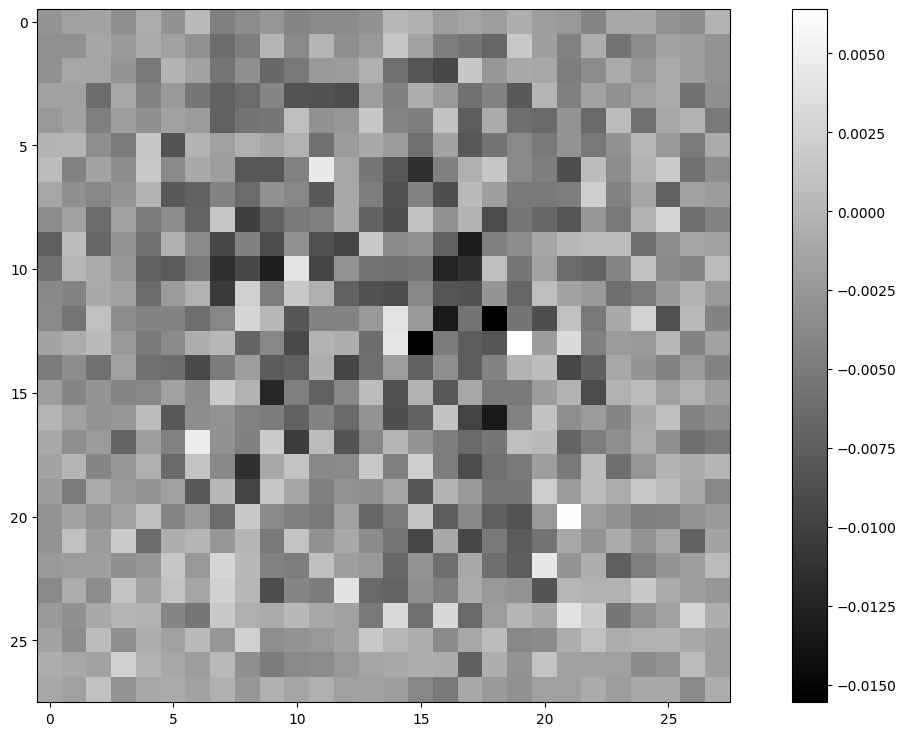

In [18]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

x = noise(1)
gen = Generator2()
gen.to(device) # Move the entire model to the device, including its parameters
img = gen(x).detach().cpu().numpy()[0, :,:]
plt.imshow(img, cmap='gray')
plt.colorbar()

Pour l'instant, ces images ne ressemble pas à des chiffres. On verra plus tard comment elles vont évoluer au cours de l'entraînement.

Le Discriminator est un modèle de classification binaire, qui, étant donné une image, doit décider si elle provient du jeu de données (label 1), ou si c'est une création du Generator (label 0).

In [19]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_features = 784
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [20]:
class Discriminator2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=(5, 5),  padding="valid", stride=1), # 8x24x24
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # 8x12x12
            torch.nn.Conv2d(8, 16, kernel_size=(5, 5), padding="valid", stride=1), # 16x8x8
            torch.nn.Tanh(), torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2), # 16x4x4
            torch.nn.Flatten(), # 256
            torch.nn.Linear(256, 96), torch.nn.ReLU(), # 96
            torch.nn.Linear(96, 96), torch.nn.Tanh(), # 64
            torch.nn.Linear(96, 1), torch.nn.Sigmoid(), # 1
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        for layer in self.layers:
            x = layer(x)
            #print(f"{x.shape=}")
        return x


def test():
    model = Discriminator2()
    i = 4644
    img = data_train.data[i: i+100].to(torch.float32)
    y = model(img)
    assert y.shape == (100, 1)
    #print(f"{y.shape=}")

test()

Le code suivant permet d'entraîner les deux réseaux.

# ATTENTION

Si votre ordinateur n'a pas de carte graphique, l'entraînement est **extremement** lent.
Dans ce cas, vous pouvez par exemple utiliser Google Colab, en vous connectant à un environnement GPU. 

In [21]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)

In [22]:
def train_discriminator(disc, optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1. Train on Real Data
    prediction_real = disc(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = disc(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(fake_data.size(0)))
    error_fake.backward()

    # Update weights with gradients
    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(disc, optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = disc(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [23]:
device = getDevice()
disc = Discriminator2()
gen = Generator()

gen.to(device)
disc.to(device)

d_optimizer = Adam(disc.parameters(), lr=0.0002)
g_optimizer = Adam(gen.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

Epoch 0, batch 0 -- Disc loss: 1.390, Gen loss: 0.729 -- Disc prec: 50.000%
Epoch 0, batch 1 -- Disc loss: 1.380, Gen loss: 0.725 -- Disc prec: 50.050%
Epoch 0, batch 2 -- Disc loss: 1.369, Gen loss: 0.722 -- Disc prec: 55.000%
Epoch 0, batch 3 -- Disc loss: 1.358, Gen loss: 0.719 -- Disc prec: 79.800%
Epoch 0, batch 4 -- Disc loss: 1.346, Gen loss: 0.715 -- Disc prec: 98.000%
Epoch 0, batch 5 -- Disc loss: 1.335, Gen loss: 0.710 -- Disc prec: 100.000%
Epoch 0, batch 6 -- Disc loss: 1.325, Gen loss: 0.705 -- Disc prec: 100.000%
Epoch 0, batch 7 -- Disc loss: 1.316, Gen loss: 0.697 -- Disc prec: 99.350%
Epoch 0, batch 8 -- Disc loss: 1.309, Gen loss: 0.688 -- Disc prec: 62.800%
Epoch 0, batch 9 -- Disc loss: 1.302, Gen loss: 0.676 -- Disc prec: 50.000%
Epoch 0, batch 10 -- Disc loss: 1.299, Gen loss: 0.661 -- Disc prec: 50.000%
Epoch 0, batch 11 -- Disc loss: 1.300, Gen loss: 0.643 -- Disc prec: 50.000%
Epoch 0, batch 12 -- Disc loss: 1.305, Gen loss: 0.621 -- Disc prec: 50.000%
Epoch 0

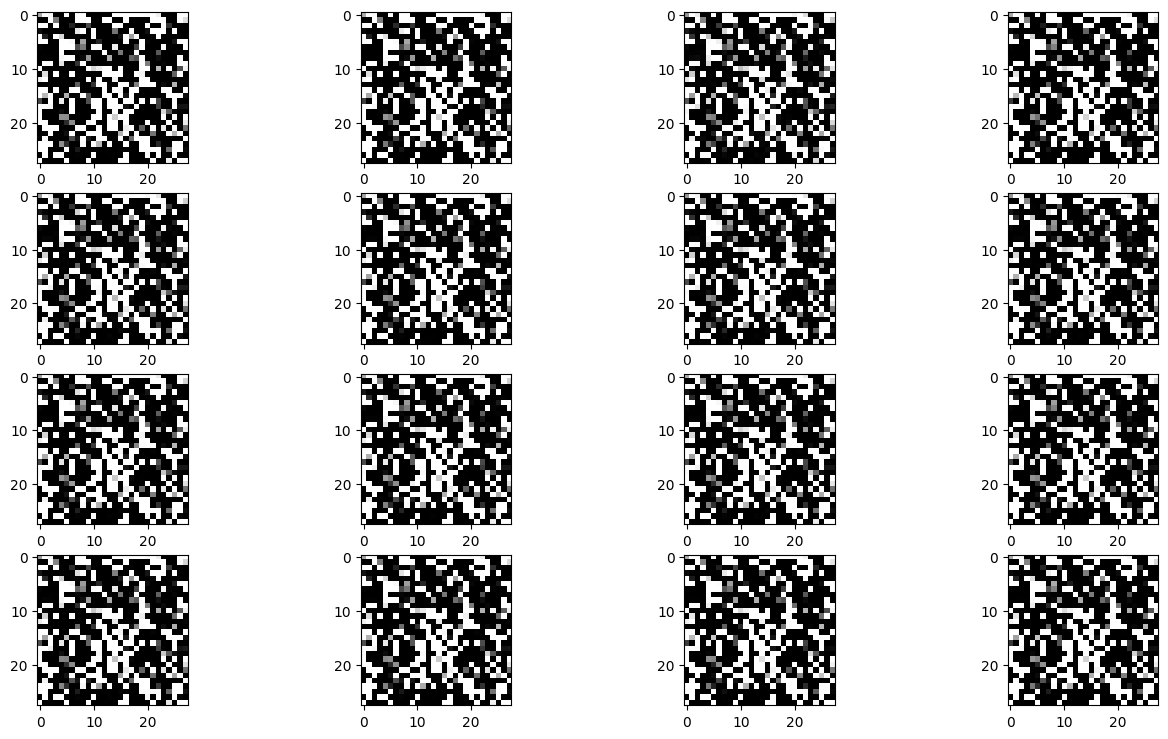

Epoch 1, batch 0 -- Disc loss: 1.065, Gen loss: 0.911 -- Disc prec: 95.800%
Epoch 1, batch 1 -- Disc loss: 1.047, Gen loss: 0.931 -- Disc prec: 95.500%
Epoch 1, batch 2 -- Disc loss: 1.029, Gen loss: 0.951 -- Disc prec: 95.700%
Epoch 1, batch 3 -- Disc loss: 1.017, Gen loss: 0.973 -- Disc prec: 94.650%
Epoch 1, batch 4 -- Disc loss: 1.009, Gen loss: 0.993 -- Disc prec: 93.200%
Epoch 1, batch 5 -- Disc loss: 0.991, Gen loss: 1.007 -- Disc prec: 93.950%
Epoch 1, batch 6 -- Disc loss: 0.978, Gen loss: 1.020 -- Disc prec: 93.650%
Epoch 1, batch 7 -- Disc loss: 0.967, Gen loss: 1.030 -- Disc prec: 93.550%
Epoch 1, batch 8 -- Disc loss: 0.948, Gen loss: 1.037 -- Disc prec: 94.000%
Epoch 1, batch 9 -- Disc loss: 0.939, Gen loss: 1.043 -- Disc prec: 93.650%
Epoch 1, batch 10 -- Disc loss: 0.909, Gen loss: 1.048 -- Disc prec: 95.300%
Epoch 1, batch 11 -- Disc loss: 0.904, Gen loss: 1.052 -- Disc prec: 95.250%
Epoch 1, batch 12 -- Disc loss: 0.890, Gen loss: 1.060 -- Disc prec: 94.950%
Epoch 1, 

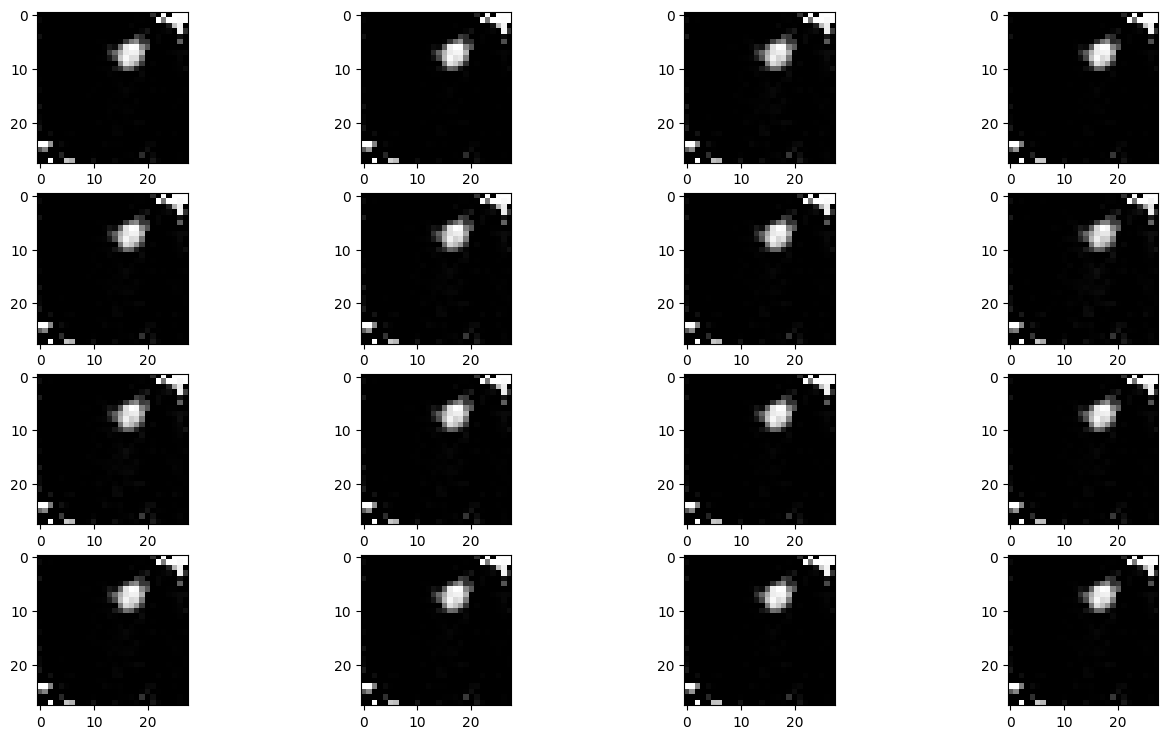

Epoch 6, batch 0 -- Disc loss: 1.303, Gen loss: 0.875 -- Disc prec: 78.200%
Epoch 6, batch 1 -- Disc loss: 1.209, Gen loss: 0.934 -- Disc prec: 80.750%
Epoch 6, batch 2 -- Disc loss: 1.117, Gen loss: 0.983 -- Disc prec: 83.750%
Epoch 6, batch 3 -- Disc loss: 1.034, Gen loss: 1.004 -- Disc prec: 88.350%
Epoch 6, batch 4 -- Disc loss: 0.982, Gen loss: 1.016 -- Disc prec: 89.550%
Epoch 6, batch 5 -- Disc loss: 0.946, Gen loss: 1.024 -- Disc prec: 91.350%
Epoch 6, batch 6 -- Disc loss: 0.916, Gen loss: 1.032 -- Disc prec: 92.200%
Epoch 6, batch 7 -- Disc loss: 0.883, Gen loss: 1.038 -- Disc prec: 94.050%
Epoch 6, batch 8 -- Disc loss: 0.856, Gen loss: 1.049 -- Disc prec: 94.900%
Epoch 6, batch 9 -- Disc loss: 0.820, Gen loss: 1.063 -- Disc prec: 95.750%
Epoch 6, batch 10 -- Disc loss: 0.821, Gen loss: 1.079 -- Disc prec: 95.100%
Epoch 6, batch 11 -- Disc loss: 0.772, Gen loss: 1.106 -- Disc prec: 96.800%
Epoch 6, batch 12 -- Disc loss: 0.774, Gen loss: 1.140 -- Disc prec: 95.600%
Epoch 6, 

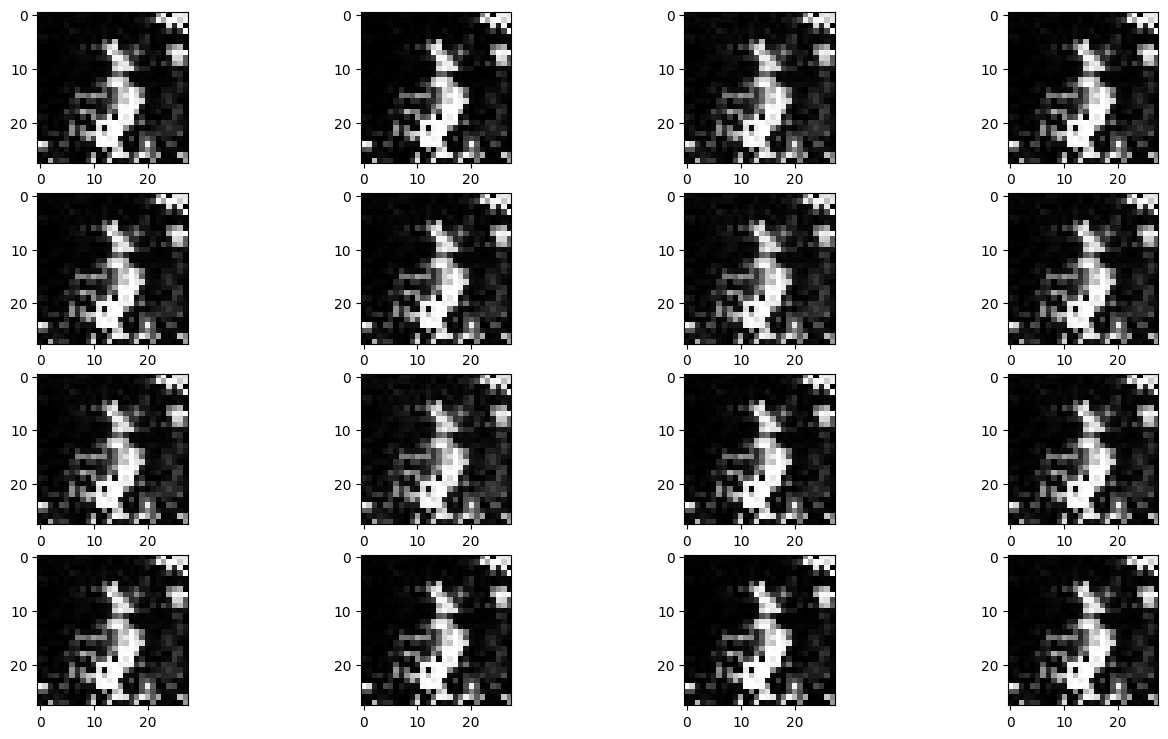

Epoch 11, batch 0 -- Disc loss: 1.419, Gen loss: 0.703 -- Disc prec: 29.450%
Epoch 11, batch 1 -- Disc loss: 1.405, Gen loss: 0.743 -- Disc prec: 29.100%
Epoch 11, batch 2 -- Disc loss: 1.354, Gen loss: 0.806 -- Disc prec: 49.650%
Epoch 11, batch 3 -- Disc loss: 1.311, Gen loss: 0.855 -- Disc prec: 77.950%
Epoch 11, batch 4 -- Disc loss: 1.267, Gen loss: 0.899 -- Disc prec: 77.100%
Epoch 11, batch 5 -- Disc loss: 1.233, Gen loss: 0.932 -- Disc prec: 77.250%
Epoch 11, batch 6 -- Disc loss: 1.246, Gen loss: 0.950 -- Disc prec: 76.350%
Epoch 11, batch 7 -- Disc loss: 1.181, Gen loss: 0.956 -- Disc prec: 78.650%
Epoch 11, batch 8 -- Disc loss: 1.170, Gen loss: 0.963 -- Disc prec: 78.950%
Epoch 11, batch 9 -- Disc loss: 1.096, Gen loss: 0.978 -- Disc prec: 82.150%
Epoch 11, batch 10 -- Disc loss: 1.115, Gen loss: 0.979 -- Disc prec: 80.900%
Epoch 11, batch 11 -- Disc loss: 1.067, Gen loss: 0.980 -- Disc prec: 83.750%
Epoch 11, batch 12 -- Disc loss: 1.054, Gen loss: 0.993 -- Disc prec: 83.7

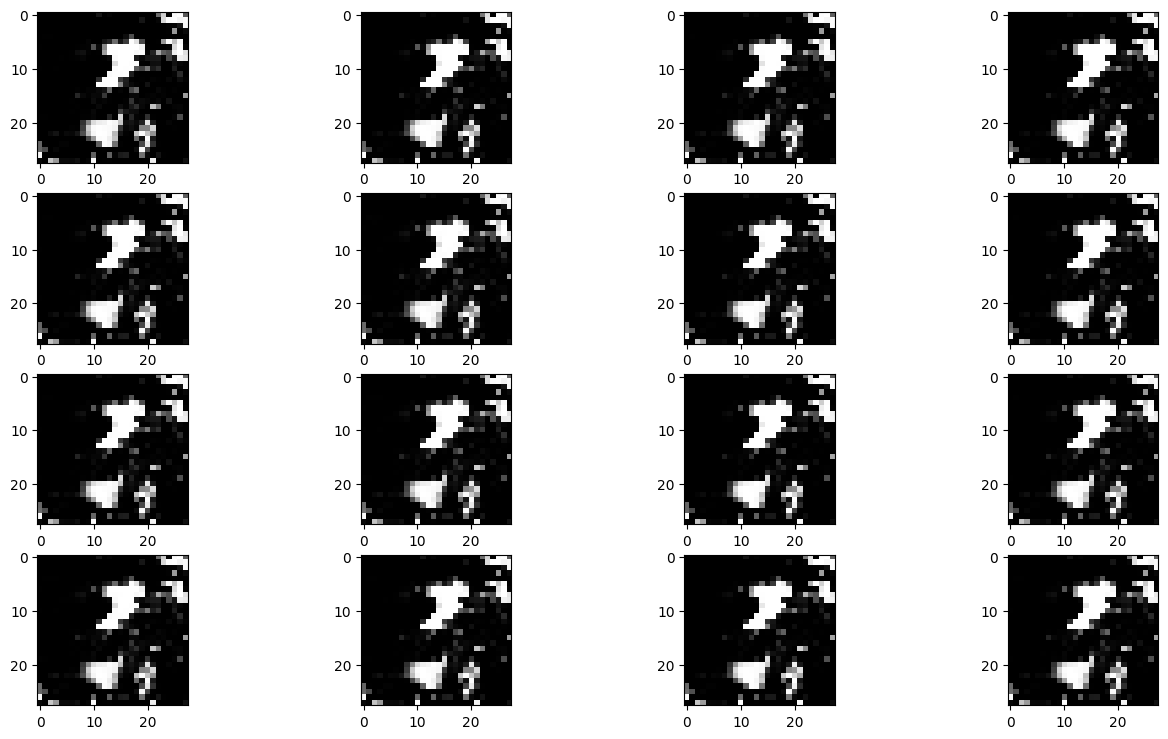

Epoch 16, batch 0 -- Disc loss: 0.392, Gen loss: 2.301 -- Disc prec: 93.800%
Epoch 16, batch 1 -- Disc loss: 0.419, Gen loss: 2.151 -- Disc prec: 93.800%
Epoch 16, batch 2 -- Disc loss: 0.441, Gen loss: 1.998 -- Disc prec: 93.950%
Epoch 16, batch 3 -- Disc loss: 0.435, Gen loss: 1.939 -- Disc prec: 95.400%
Epoch 16, batch 4 -- Disc loss: 0.492, Gen loss: 1.948 -- Disc prec: 94.550%
Epoch 16, batch 5 -- Disc loss: 0.524, Gen loss: 2.019 -- Disc prec: 93.400%
Epoch 16, batch 6 -- Disc loss: 0.568, Gen loss: 2.086 -- Disc prec: 93.400%
Epoch 16, batch 7 -- Disc loss: 0.634, Gen loss: 2.136 -- Disc prec: 91.750%
Epoch 16, batch 8 -- Disc loss: 0.677, Gen loss: 2.198 -- Disc prec: 89.200%
Epoch 16, batch 9 -- Disc loss: 0.740, Gen loss: 2.218 -- Disc prec: 87.600%
Epoch 16, batch 10 -- Disc loss: 0.835, Gen loss: 2.156 -- Disc prec: 84.350%
Epoch 16, batch 11 -- Disc loss: 0.851, Gen loss: 1.987 -- Disc prec: 83.700%
Epoch 16, batch 12 -- Disc loss: 0.902, Gen loss: 1.724 -- Disc prec: 83.0

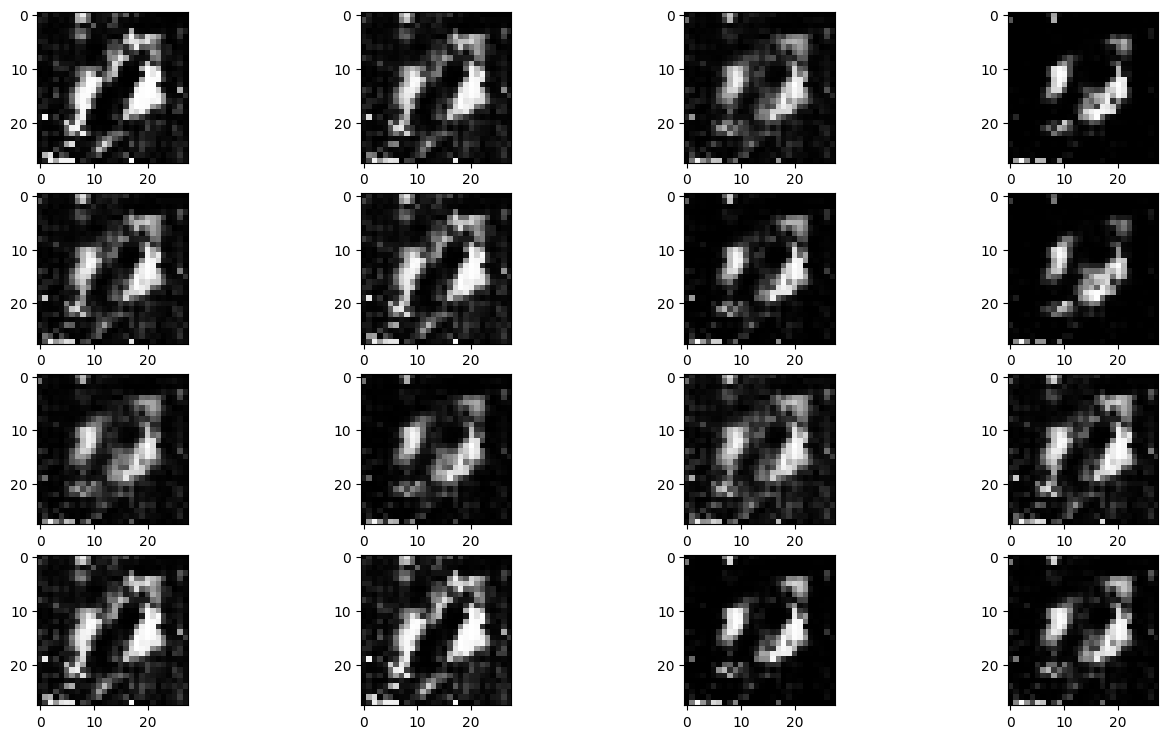

In [24]:
# Number of epochs
num_epochs = 20

num_test_samples = 16
test_noise = noise(num_test_samples)

for epoch in range(num_epochs):
    for n_batch, (real_data, target) in enumerate(train_datas):

        # 1. Train Discriminator
        real_data = real_data.to(device)
        # Generate fake data
        fake_data = gen(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            disc, d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = gen(noise(real_data.size(0)))
        # Train G
        g_error = train_generator(disc, g_optimizer, fake_data)

        # Log error
        d_prec = (sum(d_pred_real > 0.5) + sum(d_pred_fake < 0.5))/ (2*real_data.size(0))
        #print(d_pred_real, d_pred_fake)
        print(f"Epoch {epoch}, batch {n_batch}", end=" -- ")
        print(f"Disc loss: {d_error:.3f}, Gen loss: {g_error:.3f}", end= " -- ")
        print(f"Disc prec: {d_prec.item()*100:.3f}%")

    # Display Progress
    if (epoch % 5 == 0) or (epoch == num_epochs-1):
        # Display Images
        test_images = gen(test_noise).data.cpu()
        plt.figure()
        for i in range(num_test_samples):
            plt.subplot(4, 4, i+1)
            plt.imshow(test_images[i,:,:], cmap='gray')
        plt.show()

Les questions ci-dessous sont pour vous guider et pour aller plus loin. Elles peuvent prendre beaucoup de temps, notamment à cause de l'entraînement. Il n'est pas attendu que vous y ayez répondu dans votre rendu moodle (Questions Bonus).

**Q1**: Lancer l'entraînement, et regarder si ça marche. Comprendre le code, et vous l'approprier.

**Q2**: Remplacez le discriminator par un réseau utilisant des couches convolutionnelles, comme à l'exercice 2. Arrivez-vous à reproduire l'expérience ?